## Efficient Manifold Density Estimator

EMDE can be thought of as an unsupervised super-embedder which translates and compresses different embeddings of different types or modalitys to the same kind of representation – the sketch. The sketches are sparse by design. Moreover, they allow for easy aggregation of multiple events/items/behaviors in one sketch. Such aggregate sketches can be thought of as histograms representing the occurrence rate of various events. 

EMDE uses a density-aware manifold partitioning method in order to create meaningful manifold regions. Each region holds samples which are similar according to the distance metric expressed within the embedding space which spans the manifold (e.g. produced by Cleora). The resulting region assignment vectors (sketches) can be generated from different types of input and concatenated to serve as an input to a model that will be trained for a given task.

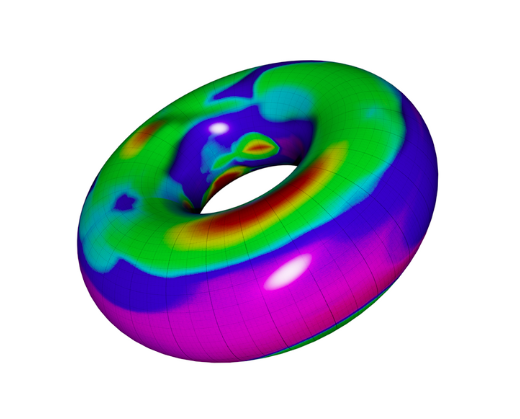

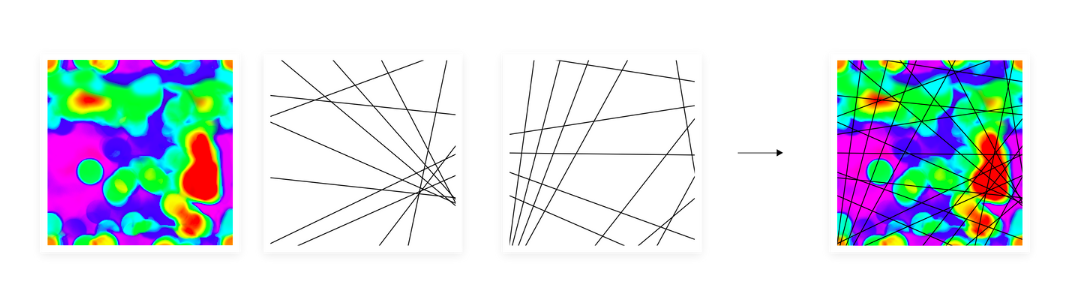

In [2]:
import sys
import numpy as np
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

### This part creates sparse codes from embedding vectors
VCoder is a class that creates sparse codes that map to the regions on a manifold and are used as an indices to increment the sketch

In [3]:
class VCoder(object): 
  def __init__(self, sketch_depth, sketch_width, input_dim):
    self.sketch_depth = sketch_depth
    self.sketch_width = sketch_width
    self.input_dim = input_dim
    self.scaler = StandardScaler()
    if self.input_dim < 10000:
        # 16 is the number of hyperplanes dividing data manifold
        self.sp = GaussianRandomProjection(n_components = 16*sketch_depth)
    else:
        self.sp = SparseRandomProjection(n_components = 16*sketch_depth, density = 1/3.0)

  '''
  To cut the manifold into nonempty parts we introduce the modified version of the LSH algorithm – 
  Density-depended LSH. We generate K random vectors r_i and calculate hash codes with the provided formula: 
  hash_i(v) = sgn(v · r_i −b_i) 
  where v represents the input vector and bi is a bias drawn from the data-dependent quantile function of v · r_i
  '''
  def set_biases(self, v):        
    self.biases = np.array([np.percentile(v[:, i], q=50, axis=0) for i in range(v.shape[1])])
    
  
  def discretize(self, v):
    return ((np.sign(v - self.biases)+1)/2).astype(np.uint8)


  def fit(self, v):
    self.scaler = self.scaler.fit(v)    
    vv = self.scaler.transform(v)    
    self.sp = self.sp.fit(vv)
    vvv = self.sp.transform(vv)
    self.set_biases(vvv)

  
  def transform(self, v):
    v = self.scaler.transform(v)
    v = self.sp.transform(v)
    '''
     Here, we create a binary vector where for each hyperplane we track if the encoded embedding is 
     beneath or below the hyperplane
     binary vector size: number of hyperplanes x number of separate manifold divisions (sketch_depth) 
    ''' 
    v = self.discretize(v)
    v = np.packbits(v, axis=-1)
    v = np.frombuffer(np.ascontiguousarray(v), dtype=np.uint16).reshape(v.shape[0], -1)
    # 2^16 regions are created so we map it to the sketch_width
    v = v % self.sketch_width 
    return v


  def transform_to_absolute_codes(self, v):
    codes = self.transform(v)
    pos_index = np.array([i*self.sketch_width for i in range(self.sketch_depth)], dtype=np.int_)
    index = codes + pos_index
    return index


  def all_to_sketch(self, v):
    codes = self.transform(v)
    pos_index = np.array([i*self.sketch_width for i in range(self.sketch_depth)], dtype=np.int_)
    index = codes + pos_index
    x = np.zeros(self.sketch_depth*self.sketch_width)
    for ind in index:   
        x[ind] += 1
    return x


  def query(self, sketch, v):    
    codes = self.transform_to_absolute_codes(v)
    x = sketch[:, codes]        
    x = np.log(1e-6+x)
    x = x.mean(-1)
    x = np.exp(x)
    return x

### Let's assume we have some embeddings, 5000 items of dimensionality 1024

In [4]:
item_vectors = np.random.randn(5000, 1024)
item_vectors

array([[ 0.4498957 , -0.09536969, -1.68214055, ..., -1.21532375,
        -0.05129525, -0.26363568],
       [ 1.00376783, -0.54318149, -0.29118382, ...,  0.17284428,
        -0.44329261,  1.90083157],
       [-0.66161781,  0.65461847, -1.94771497, ...,  0.96233028,
        -0.45169739,  1.76628635],
       ...,
       [ 1.58193462, -1.81379382, -0.36172661, ..., -0.36640836,
        -0.98998379, -2.50949986],
       [-0.56152988, -0.20148746, -0.47562753, ...,  0.94971673,
         0.10044494, -0.27595511],
       [ 0.66075168, -0.61312548,  0.11612634, ..., -1.6854816 ,
         1.05926052, -0.08744537]])

### We will create sketches of 64 x 256 dimension

*sketch_width* corresponds to the number of buckets resulting from single manifold division\
*sketch_depth* is the number of independent divisions

In [5]:
DEPTH=64
WIDTH=256

v = VCoder(sketch_depth=DEPTH, sketch_width=WIDTH, input_dim=1024)

### In the fit phase we create manifold divisions, which establish a sketch structure
**After fitting we can encode any input**

In [6]:
v.fit(item_vectors)

### In transform phase we create codes for each item vector

In [7]:
item_sparse_codes_relative = v.transform(item_vectors)

### These are the sparse codes in the relative form
For each of 64 depth levels, there is one value from 0 to sketch_width \
To make it suitable for further processing we transform them into absolute form where for n-th depth level the value is: \
n * sketch_width + relative_code

In [8]:
item_sparse_codes_relative, item_sparse_codes_relative.shape

(array([[144,  53, 137, ..., 218,  78, 179],
        [227, 251, 220, ..., 205, 174,  35],
        [ 18, 154, 210, ...,  51,  37,   7],
        ...,
        [ 20,  53, 148, ..., 222, 177,  52],
        [137, 139, 203, ...,  13,  75, 159],
        [206, 178, 162, ..., 102, 211, 153]], dtype=uint16),
 (5000, 64))

In [9]:
item_sparse_codes_absolute = v.transform_to_absolute_codes(item_vectors)

### Absolute codes are easier to handle

In [10]:
item_sparse_codes_absolute, item_sparse_codes_absolute.shape

(array([[  144,   309,   649, ..., 15834, 15950, 16307],
        [  227,   507,   732, ..., 15821, 16046, 16163],
        [   18,   410,   722, ..., 15667, 15909, 16135],
        ...,
        [   20,   309,   660, ..., 15838, 16049, 16180],
        [  137,   395,   715, ..., 15629, 15947, 16287],
        [  206,   434,   674, ..., 15718, 16083, 16281]]),
 (5000, 64))

### We can also use the VCoder to encode some new items
With the algorithm fitted on some representative dataset, we can generate codes for new vectors that are created by the same embedding method. We are mapping the place on a manifold where a new vector resides encapsulating its similarity to other entities

In [11]:
some_new_item_vectors = np.random.randn(200, 1024)

In [12]:
new_item_codes = v.transform_to_absolute_codes(some_new_item_vectors)

In [13]:
new_item_codes

array([[  200,   442,   678, ..., 15838, 16034, 16222],
       [  190,   490,   625, ..., 15817, 16127, 16174],
       [   76,   258,   524, ..., 15705, 16070, 16289],
       ...,
       [   73,   501,   708, ..., 15828, 16089, 16365],
       [  238,   427,   607, ..., 15647, 15914, 16242],
       [  183,   491,   517, ..., 15749, 16094, 16319]])

### Let's assume we have a user with 25 historic interactions and 25 "future" interactions — ones we want to predict. Our goal is to make a network predicting future interactions based on the user history

In [14]:
NUM_ITEMS = 25
user_interacion_item_ids_historic = np.random.randint(low=0, high=5000, size=(NUM_ITEMS,))
user_interacion_item_ids_future = np.random.randint(low=0, high=5000, size=(NUM_ITEMS,))

### We have ids of items the user interacted with

In [15]:
user_interacion_item_ids_historic, user_interacion_item_ids_future

(array([2123, 1035, 3692,  256, 2213, 3732, 2491, 3974, 4569, 1294, 4447,
        2365, 1113, 3428, 3011, 1725, 1918, 4239, 3474, 2587, 3388, 2741,
        2791, 4154,  974]),
 array([3921, 2854,  799,  667, 4203, 4216, 2467, 4387, 4533,  472, 1986,
        3433, 1747, 3324, 2825, 3057, 4083, 4125, 4847, 2536, 3969, 1237,
        1364, 4523, 4971]))

### Now we'll create the actual "sketch vectors" of the user from aggregated item interactions

In [16]:
def create_user_vector_from_item_ids(user_item_ids):
    sketch = np.zeros((DEPTH*WIDTH,), dtype=np.float32)
    for item in user_item_ids:
        item_codes = item_sparse_codes_absolute[item]
        sketch[item_codes] += 1.
    return sketch    

#### User sketch size

In [17]:
WIDTH*DEPTH

16384

In [19]:
user_sketch_historic = create_user_vector_from_item_ids(user_interacion_item_ids_historic)
user_sketch_future = create_user_vector_from_item_ids(user_interacion_item_ids_future)
print(f'sketch shape: {user_sketch_historic.shape}')
with np.printoptions(threshold=np.inf):
    print(user_sketch_historic[:WIDTH])

sketch shape: (16384,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 2.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### On each depth level all items should be added to relevant sketch buckets

In [21]:
assert(user_sketch_historic.sum() / NUM_ITEMS == DEPTH)
assert(user_sketch_future.sum() / NUM_ITEMS == DEPTH)

### We want the inputs to NN to be width-wise L2 normalized (for initialization), and the outputs to be width-wise L1 normalized (for cross-entropy loss)

In [22]:
def prepare_sketch_for_neural_input(sketch):
    sketch = sketch.reshape(DEPTH, WIDTH)
    sketch = sketch / (1e-6 + np.sqrt((sketch**2).sum(-1, keepdims=True)))
    sketch = sketch.reshape(-1)
    return sketch

In [23]:
def prepare_sketch_for_neural_target(sketch):
    sketch = sketch.reshape(DEPTH, WIDTH)
    sketch = sketch / (1e-6 + sketch.sum(-1, keepdims=True))
    sketch = sketch.reshape(-1)
    return sketch

In [24]:
history_sketch = prepare_sketch_for_neural_input(user_sketch_historic)
print(f'sketch shape: {history_sketch.shape}')
with np.printoptions(threshold=np.inf):
    print(history_sketch[:WIDTH])

sketch shape: (16384,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.19245006
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.19245006 0.19245006 0.         0.         0.         0.19245006
 0.         0.         0.         0.         0.         0.
 0.19245006 0.         0.19245006 0.         0.         0.38490012
 0.         0.         0.19245006 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.19245006 0.         0.         0.         0.         0.
 0.      

In [26]:
future_sketch = prepare_sketch_for_neural_target(user_sketch_future)
print(f'sketch shape: {future_sketch.shape}')
with np.printoptions(threshold=np.inf):
    print(future_sketch[:WIDTH])

sketch shape: (16384,)
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.04 0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.04 0.   0.   0.   0.04
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.
 0.   0.04 0.   0.   0.04 0.   0.   0.   0.   0.04 0.   0.   0.   0.04
 0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.
 0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.
 0.   0.04 0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0

### Let's check the normalization

In [49]:
(history_sketch.reshape(DEPTH, WIDTH)**2).sum(-1)

array([0.9999997 , 0.99999964, 0.9999997 , 0.99999964, 0.99999964,
       0.9999997 , 0.99999976, 0.9999997 , 0.99999964, 0.99999964,
       0.99999964, 0.99999964, 0.99999964, 0.99999964, 0.9999997 ,
       0.99999964, 0.9999997 , 0.99999964, 0.99999964, 0.99999976,
       0.9999997 , 0.99999964, 0.99999964, 0.99999976, 0.99999964,
       0.99999964, 0.99999964, 0.9999997 , 0.99999964, 0.99999964,
       0.9999996 , 0.99999964, 0.9999997 , 0.99999976, 0.99999964,
       0.99999964, 0.99999964, 0.9999997 , 0.99999976, 0.99999964,
       0.99999964, 0.99999964, 0.9999997 , 0.99999964, 0.99999964,
       0.9999996 , 0.99999976, 0.99999976, 0.99999964, 0.99999964,
       0.9999997 , 0.99999976, 0.9999997 , 0.99999964, 0.99999964,
       0.99999964, 0.9999996 , 0.99999964, 0.99999964, 0.99999964,
       0.99999976, 0.99999976, 0.9999997 , 0.99999964], dtype=float32)

In [29]:
future_sketch.reshape(DEPTH, WIDTH).sum(-1)

array([0.9999999 , 0.9999999 , 0.9999999 , 0.99999994, 0.99999994,
       0.9999999 , 0.9999999 , 0.99999994, 0.9999999 , 0.9999999 ,
       0.99999994, 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.99999994, 0.99999994, 0.9999999 , 0.9999999 , 0.99999994,
       0.99999994, 0.99999994, 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.99999994, 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.99999994, 0.9999999 , 0.9999999 ,
       0.99999994, 0.9999999 , 0.9999999 , 0.9999999 , 0.99999994,
       0.9999999 , 0.9999999 , 0.99999994, 0.99999994], dtype=float32)

### Now we'll build a simple but expressive net, and we'll apply the sketch-cross-entropy (width-wise)

In [58]:
def categorical_cross_entropy(y_pred, y_true, depth, width):
    y_pred = y_pred.view(-1, depth, width)
    y_true = y_true.view(-1, depth, width)
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    return -(y_true * torch.log(y_pred)).sum(dim=-1).mean()

class ResBlock(nn.Module):
    def __init__(self, codesize):
        super().__init__()
        self.codesize = codesize
        self.l1 = nn.Linear(1*self.codesize, 512)
        self.l2 = nn.Linear(512, 1*self.codesize)
        self.bn1 = nn.BatchNorm1d(self.codesize)
        self.bn2 = nn.BatchNorm1d(512)
    
    def forward(self, x):
        return self.l2(F.leaky_relu(self.bn2(self.l1(self.bn1(x)))))

class Model(nn.Module):
    def __init__(self, codesize):
        super().__init__()
        self.codesize = codesize
        self.l1 = ResBlock(self.codesize)
        self.l2 = ResBlock(self.codesize)
        self.l3 = ResBlock(self.codesize)
        self.l4 = ResBlock(self.codesize)
        self.l5 = ResBlock(self.codesize)
        self.l6 = ResBlock(self.codesize)

    def forward(self, x):
        x = x + self.l1(x)
        x = x + self.l2(x)
        x = x + self.l3(x)
        x = x + self.l4(x)
        x = x + self.l5(x)
        x = x + self.l6(x)
        y = x
        y = F.softmax(y.view(y.shape[0], -1, WIDTH), -1).view(y.shape[0], -1)
        return y

In [59]:
m = Model(DEPTH*WIDTH)

### BatchNorm needs a batch size of more than 1, so let's repeat the input (and target) 5 times:

In [60]:
inp = torch.cat([torch.from_numpy(history_sketch).unsqueeze(0)]*5)

In [61]:
out = m(inp)

In [62]:
target = torch.cat([torch.from_numpy(future_sketch).unsqueeze(0)]*5)

In [63]:
loss = categorical_cross_entropy(out, target, DEPTH, WIDTH)

In [64]:
loss.item()

5.546372413635254

### Now is time for model training, which would make sense, If we had some real data :) Here, we omit this step 

NOTE: One can use multiple sketches (e.g. of different modalities or embedding types) both on the input  & output. Also, different sketches can be used on the input & output with some small changes to the network. 

### Now, how do we obtain scores from the network output?
### Let's consider some items we want to score:

In [65]:
interesting_items = np.concatenate([
    user_interacion_item_ids_historic, # let's take the original input items
    np.random.randint(low=0, high=5000, size=(25,))] # and add some random new items
)

interesting_item_codes = item_sparse_codes_absolute[interesting_items]

In [66]:
interesting_item_codes, interesting_item_codes.shape

(array([[  123,   433,   556, ..., 15838, 16093, 16281],
        [  204,   293,   713, ..., 15829, 15907, 16267],
        [  241,   466,   558, ..., 15840, 15909, 16253],
        ...,
        [    1,   462,   704, ..., 15616, 15884, 16237],
        [    4,   510,   752, ..., 15634, 15964, 16250],
        [  166,   282,   689, ..., 15656, 16102, 16247]]),
 (50, 64))

### We have 50 interesting items: 25 old ones from input and 25 random new ones

### Let's check their scores

To calculate a score for a given item we look up scores from relevant indices of model output. For each depth-level, we consider item code and we take the score from the output sketch, which was returned for a given code. We aggregate them using a geometric mean.

In [80]:
out_sketch = out.detach().numpy()
interesting_item_scores = np.exp(np.log(1e-7 + out_sketch[:,interesting_item_codes]).mean(-1)) # This is the geometric mean

interesting_item_scores[0]

array([0.00470725, 0.00471589, 0.0047949 , 0.00469614, 0.00464844,
       0.00467167, 0.00475304, 0.00472367, 0.00470599, 0.00471167,
       0.00475246, 0.0046742 , 0.00480478, 0.00465281, 0.00476379,
       0.00474374, 0.00473943, 0.00470238, 0.00475069, 0.00474224,
       0.00466885, 0.00471705, 0.00461526, 0.00474846, 0.00474756,
       0.00388214, 0.00389984, 0.00387548, 0.00392014, 0.00391718,
       0.00386749, 0.00389549, 0.00384644, 0.00389097, 0.0038772 ,
       0.0038632 , 0.00394922, 0.00385049, 0.00394268, 0.00385958,
       0.00382987, 0.0038605 , 0.00384256, 0.00391716, 0.00388904,
       0.00382834, 0.0038742 , 0.00395983, 0.00389075, 0.00389383],
      dtype=float32)

### Even though the network has not been trained, it still preserves some score difference between input & random items:

In [68]:
interesting_item_scores[0][:25].mean(), interesting_item_scores[0][25:].mean()

(0.004718095, 0.0038849441)

### Let's see if the original input items are top scorers. The net has NOT been trained, but it has residual connections, so the input items should be roughly preserved as top scorers:

In [82]:
np.argsort(-interesting_item_scores[0], -1)<25

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

### To see the clear difference, we can score items against original input

In [70]:
in_sketch = inp.detach().numpy()
interesting_item_scores = np.exp(np.log(1e-7 + in_sketch[:,interesting_item_codes]).mean(-1))

interesting_item_scores[0]

array([1.9992375e-01, 2.0877510e-01, 2.0877510e-01, 2.1104848e-01,
       1.9563977e-01, 1.9992372e-01, 1.9992375e-01, 1.9902706e-01,
       2.0210074e-01, 2.0430148e-01, 2.0559993e-01, 1.9992375e-01,
       2.0430146e-01, 2.0467782e-01, 2.0915967e-01, 2.1334666e-01,
       2.1010196e-01, 2.0430148e-01, 2.1010196e-01, 2.1010196e-01,
       1.9777013e-01, 1.9777016e-01, 1.9777016e-01, 2.0430148e-01,
       2.0652619e-01, 3.0975153e-07, 4.8769391e-07, 1.9717622e-07,
       6.0968597e-07, 3.0972672e-07, 3.1045923e-07, 4.8716765e-07,
       2.4733728e-07, 2.4932186e-07, 3.1008642e-07, 4.8692988e-07,
       7.6341468e-07, 1.9705779e-07, 7.6482183e-07, 6.1738831e-07,
       1.2529890e-07, 3.0956576e-07, 1.9740500e-07, 3.8853696e-07,
       3.8853696e-07, 3.8796674e-07, 1.9684516e-07, 1.2021635e-06,
       3.8922192e-07, 3.1027275e-07], dtype=float32)

In [43]:
interesting_item_scores[0][:25].mean(), interesting_item_scores[0][25:].mean()

(0.204516, 0.00780397)

In [44]:
np.argsort(-interesting_item_scores[0], -1)<25

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

### That's it! With EMDE we can encode and aggregate imges, graphs or text embeddings, etc.  When we want to combine multiple item modalities, they can be concatenated either before or after sketch encoding 

NOTE: During the creation of a sketch from interactions, arbitrary non-negative scalars can be used, e.g. amounts, time durations, instead of simple incidence counts. These settings tend to work very well.

### Enjoy!